## example

In [37]:
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
import ast

In [38]:
map_image = cv2.imread(r"ref_image\map\book_fair_2019.jpg")
cam_image = cv2.imread(r"ref_image\cam\roi\front_room_roi.png")

In [39]:
with open("H_cam2map.json", "r") as f:
    transform = json.load(f)

H = np.array(transform["match_front_room"])
H

array([[ 0.95499152,  1.44536406,  0.05376705],
       [-0.02739988,  1.65504677,  0.10712096],
       [-0.07299328,  2.60997656,  1.        ]])

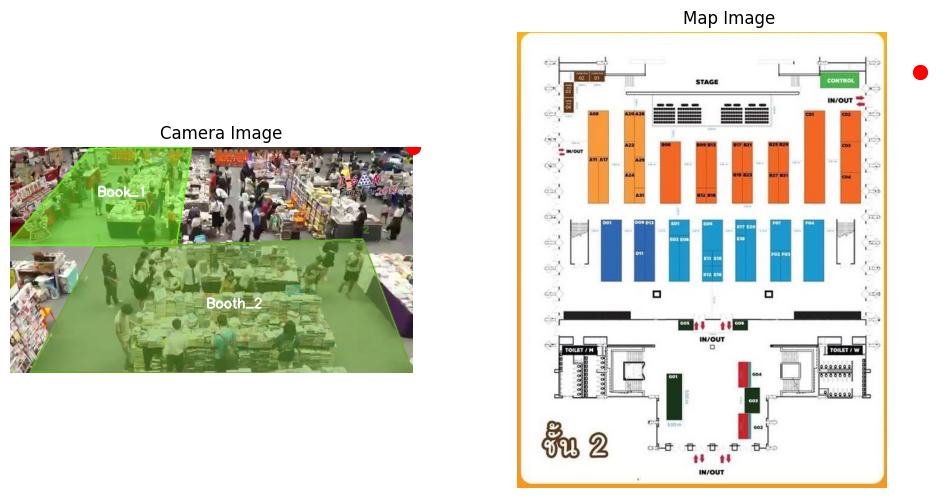

In [40]:
example_point = np.array([1,0, 1])
output_point = H @ example_point
tranformed_point = output_point[:2] / output_point[2]
tranformed_point

# plot map and cam
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.scatter(example_point[0] * cam_image.shape[1], example_point[1] * cam_image.shape[0], color='red', s=100, label='Example Point')
plt.title("Camera Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
plt.scatter(tranformed_point[0] * map_image.shape[1], tranformed_point[1] * map_image.shape[0], color='red', s=100, label='Transformed Point')
plt.title("Map Image")
plt.axis("off")


plt.show()


In [41]:
# โหลด CSV detections
df = pd.read_csv(r"detections_log.csv")

# เลือก frame_id ที่ต้องการ
frame_id = 0
frame_df = df[df["frame_id"] == frame_id]

# เตรียม list สำหรับเก็บจุดที่แปลงแล้ว
transformed_points = []

for i, row in frame_df.iterrows():
    xy_str = row["person_xy"]  # เช่น "[0.4189, 0.8903]"
    try:
        xy = eval(xy_str)  # แปลง string → list [x, y]
    except:
        continue  # ถ้า format ไม่ถูกข้าม

    # สร้างจุดในรูปแบบ homogeneous (x, y, 1)
    example_point = np.array([xy[0], xy[1], 1])

    # คูณกับ H matrix
    output_point = H @ example_point

    # Normalize กลับมาเป็น (x, y)
    transformed_point = output_point[:2] / output_point[2]
    transformed_points.append(transformed_point)

# Plot จุดทั้งหมดบน map
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))

map_h, map_w = map_image.shape[:2]
for pt in transformed_points:
    plt.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

plt.title(f"Transformed Points for frame {frame_id}")
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'detections_log.csv'

## fill_missing

In [47]:
import pandas as pd
import ast

# โหลด CSV detections
df = pd.read_csv(r"detections_log_front_room_2.csv")

# แปลง string list ให้เป็น list จริง ๆ (ใช้ ast.literal_eval ปลอดภัยกว่า eval)
df['person_box'] = df['person_box'].apply(ast.literal_eval)
df['person_xy'] = df['person_xy'].apply(ast.literal_eval)

# เตรียมเก็บแถวทั้งหมดและแถวที่เติม
all_rows = []
added_rows = []

# เก็บข้อมูลล่าสุดของแต่ละ person_id
last_data_per_person = {}
last_frame_per_person = {}

for idx, row in df.iterrows():
    frame_id = row["frame_id"]
    person_id = row["person_id"]

    if person_id in last_data_per_person:
        gap = frame_id - last_frame_per_person[person_id]
        if gap > 1 and gap <= 30:
            # เติมข้อมูล frame ที่หายไปโดยการ interpolate ค่า
            for f in range(last_frame_per_person[person_id] + 1, frame_id):
                ratio = (f - last_frame_per_person[person_id]) / gap
                interp_box = [
                    round(last_data_per_person[person_id]['person_box'][i] * (1 - ratio) + row['person_box'][i] * ratio, 4)
                    for i in range(4)
                ]
                interp_xy = [
                    round(last_data_per_person[person_id]['person_xy'][i] * (1 - ratio) + row['person_xy'][i] * ratio, 4)
                    for i in range(2)
                ]
                added_row = {
                    "frame_id": f,
                    "timestamp": None,
                    "video_time_sec": None,
                    "person_id": person_id,
                    "person_box": interp_box,
                    "person_xy": interp_xy
                }
                added_rows.append(added_row)  # เก็บแถวเติมแยก
                all_rows.append(added_row)

    # เพิ่มแถวเดิม
    all_rows.append(row.to_dict())

    # อัพเดตข้อมูลล่าสุดของคนนี้
    last_data_per_person[person_id] = row
    last_frame_per_person[person_id] = frame_id

# สร้าง DataFrame ใหม่จากแถวทั้งหมด
df_interp = pd.DataFrame(all_rows)
df_interp = df_interp.sort_values(["frame_id", "person_id"]).reset_index(drop=True)

# DataFrame เฉพาะแถวเติม (interpolated rows)
df_added_only = pd.DataFrame(added_rows)
df_added_only = df_added_only.sort_values(["frame_id", "person_id"]).reset_index(drop=True)


In [48]:

df_added_only


,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy
0,36,None,None,20,"[0.2307, 0.3243, 0.2797, 0.5526]","[0.2552, 0.4385]"
1,37,None,None,20,"[0.2328, 0.326, 0.2808, 0.5492]","[0.2568, 0.4376]"
2,38,None,None,20,"[0.2349, 0.3278, 0.2819, 0.5457]","[0.2584, 0.4368]"
3,39,None,None,20,"[0.237, 0.3296, 0.283, 0.5423]","[0.26, 0.436]"
4,40,None,None,20,"[0.2391, 0.3313, 0.2841, 0.5389]","[0.2616, 0.4351]"
...,...,...,...,...,...,...
7626,19343,None,None,11793,"[0.0991, 0.3033, 0.1431, 0.4793]","[0.1211, 0.3912]"
7627,19343,None,None,11997,"[0.1868, 0.2796, 0.223, 0.4223]","[0.2049, 0.3509]"
7628,19344,None,None,11997,"[0.188, 0.2797, 0.2244, 0.4229]","[0.2062, 0.3513]"
7629,19347,None,None,11991,"[0.0142, 0.3458, 0.0726, 0.4994]","[0.0434, 0.4226]"


In [49]:
# เติม video_time_sec จาก frame_id เดียวกันที่ค่าไม่ว่าง
df_interp['video_time_sec'] = df_interp.groupby('frame_id')['video_time_sec'] \
                         .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


C:\Users\kunka\AppData\Local\Temp\ipykernel_3796\4058480214.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [50]:
df_interp[df_interp.isnull().any(axis=1)]

,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy
416,36,None,1.200,20,"[0.2307, 0.3243, 0.2797, 0.5526]","[0.2552, 0.4385]"
427,37,None,1.233,20,"[0.2328, 0.326, 0.2808, 0.5492]","[0.2568, 0.4376]"
438,38,None,1.267,20,"[0.2349, 0.3278, 0.2819, 0.5457]","[0.2584, 0.4368]"
449,39,None,1.300,20,"[0.237, 0.3296, 0.283, 0.5423]","[0.26, 0.436]"
460,40,None,1.333,20,"[0.2391, 0.3313, 0.2841, 0.5389]","[0.2616, 0.4351]"
...,...,...,...,...,...,...
251734,19343,None,644.767,11793,"[0.0991, 0.3033, 0.1431, 0.4793]","[0.1211, 0.3912]"
251744,19343,None,644.767,11997,"[0.1868, 0.2796, 0.223, 0.4223]","[0.2049, 0.3509]"
251758,19344,None,644.800,11997,"[0.188, 0.2797, 0.2244, 0.4229]","[0.2062, 0.3513]"
251797,19347,None,644.900,11991,"[0.0142, 0.3458, 0.0726, 0.4994]","[0.0434, 0.4226]"


## Test

In [ ]:
# โหลด CSV detections
df = df_interp

# กำหนดขนาดวิดีโอจากขนาด map
map_h, map_w = map_image.shape[:2]
map_w -= (map_w % 2)
map_h -= (map_h % 2)
print(f"Map image size: width={map_w}, height={map_h}")

# สร้าง VideoWriter
output_path = "output_detections_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'H264')  # ถ้า H264 ไม่ได้ ลอง XVID
out = cv2.VideoWriter(output_path, fourcc, fps=30.0, frameSize=(map_w, map_h))


if not out.isOpened():
    print("Error: VideoWriter failed to initialize!")
    exit()

frame_ids = sorted(df["frame_id"].unique())
print(f"Total frames: {len(frame_ids)}")

# วนลูปพร้อม progress bar
for frame_id in tqdm(frame_ids, desc="Processing frames"):
    frame_df = df[df["frame_id"] == frame_id]
    transformed_points = []

    for i, row in frame_df.iterrows():
        xy_str = row["person_xy"]
        try:
            xy = eval(xy_str)
        except Exception as e:
            print(f"Error parsing person_xy in frame {frame_id}, row {i}: {xy_str}, {e}")
            continue

        example_point = np.array([xy[0], xy[1], 1])
        output_point = H @ example_point
        transformed_point = output_point[:2] / output_point[2]
        transformed_points.append(transformed_point)

    fig = plt.figure(figsize=(map_w / 100, map_h / 100), dpi=100)
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)

    ax.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
    for pt in transformed_points:
        ax.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

    ax.set_title(f"Frame {frame_id}")
    ax.axis("off")

    canvas.draw()
    frame = np.asarray(canvas.renderer.buffer_rgba())[:, :, :3]
    frame = frame[:, :, ::-1]  # RGB → BGR

    if frame.shape[:2] != (map_h, map_w):
        frame = cv2.resize(frame, (map_w, map_h), interpolation=cv2.INTER_AREA)

    out.write(frame)
    plt.close(fig)

out.release()

if os.path.exists(output_path):
    print(f"✅ Video saved to {output_path}, size: {os.path.getsize(output_path)} bytes")
else:
    print("❌ Error: Output video file was not created!")